Using kernel `conda_pytorch_latest_p36`

In [1]:
# !pip install fastai
# !pip install cloudpathlib

# Import

In [2]:
import sys
sys.path.append('../../../')

In [3]:
from pathlib import Path
import os
import random
import json
from datetime import datetime
from collections import defaultdict

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import torch
import sagemaker
from sagemaker import get_execution_role
import boto3
import torch.nn as nn
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
from fastai.text.all import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, multilabel_confusion_matrix

In [5]:
from deep.constants import *
from deep.utils import *

In [6]:
%load_ext autoreload
%autoreload 2

# Data

In [7]:
def preprocessing(df):
    df = df.copy()
    df['sectors'] = df['sectors'].apply(eval)    
    df['pillars'] = df['pillars'].apply(eval)
    df['pillars'] = df['pillars'].apply(lambda x: list(set(x)))
    df['subpillars'] = df['subpillars'].apply(eval)
    return df

In [8]:
column = 'subpillars'
classes=SUBPILLARS
text_column = 'excerpt'

In [9]:
train = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.3_train.csv'))
val = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.3_val.csv'))
test = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.3_test.csv'))

In [10]:
def process_multiclass(df, train, column='pillars', classes=PILLARS):
    relevant_train = df.copy()
#     mlb = MultiLabelBinarizer(classes=PILLARS)
#     labels = mlb.fit_transform(list(train[column]))
#     relevant_train['labels'] = labels
#     relevant_train['labels'] = relevant_train['labels'].apply(';'.join())
    relevant_train = relevant_train[relevant_train[column].apply(len) > 0]
    relevant_train[column] = relevant_train[column].apply(lambda x: ';'.join(x))
#     relevant_train.sector_ids = relevant_train.sector_ids.apply(lambda x: [classes[i] for i in x][0])
# 
    
    relevant_train['is_valid'] = False if train else True
    
    return relevant_train
    
    

# Use fastai

In [11]:
train_df = process_multiclass(train, True, column=column, classes=classes)
test_df = process_multiclass(test, False, column=column, classes=classes)
df = pd.concat([train_df, test_df])

In [12]:
train_df

,entry_id,lead_id,project_id,project_title,analysis_framework_id,excerpt,dropped_excerpt,created_by_id,modified_by_id,verified,verification_last_changed_by_id,sectors,pillars,subpillars,is_valid
0,163664,35315,2028,IMMAP/DFS Syria,1306,Market monitoring by the World Food Programme recorded a 48 per cent increase in the average price of a standard reference food basket between May and June. Food prices are 240 per cent higher than in June last year.,NaN,2232,2232,False,NaN,[Food Security],[Impact],Impact->Impact On Systems And Services,False
1,162812,37820,2098,IMMAP/DFS Bangladesh,1306,Quarantine Facilities: ninety-three shelters in Camp 20 Extension are currently operating as a Quarantine Facility for contacts of confirmed cases to support early containment of the outbreak. IOM is working with World Concern/ Medair who are providing dedicated Community Health Workers (CHWs) to carry out contact follow-up and health check-up services.,NaN,657,2233,False,NaN,[Health],[Capacities & Response],Capacities & Response->International Response,False
2,164560,39796,2098,IMMAP/DFS Bangladesh,1306,"Within dimensions, markets are broadly operating at high functionality across supply chain indicators (availability of stock and resilience) but at low to moderate capacity in terms of assortment and price volatility.",NaN,1152,1152,False,NaN,[Cross],[Impact],Impact->Impact On Systems And Services,False
3,157496,38706,2098,IMMAP/DFS Bangladesh,1306,"Frontline aid workers face a heightened risk of COVID-19 infection.Since September 2019, the Government of Bangladesh has suspended 3G and 4G mobile networks and internet access in the Rohingya settlements. These restrictions have hindered the rapid dissemination of important public health messages related to COVID-19 targeting both Rohingya refugees and Bangladeshis, as well as their ability to stay connected with family and loved ones",NaN,2233,2233,False,NaN,"[Health, Logistics]","[People At Risk, Impact]",Impact->Driver/Aggravating Factors;People At Risk->Risk And Vulnerabilities;Impact->Impact On Systems And Services;Impact->Impact On People,False
5,162971,37820,2098,IMMAP/DFS Bangladesh,1306,"IOM MHPSS teams supported in coordinating and providing trainings on Protection from Sexual Exploitations and Abuse (PSEA), basic psychological skills from ITC Interpreters, mental health and psycho-social support during COVID-19 pandemic. Stress management, and the Mental Health Gap Action Programme (mhGAP) during the month seeking to build the capacity of MHPSS volunteers, teachers, doctors and community leaders. A total of 214 participants benefitted from the trainings.",NaN,657,2233,False,NaN,[Health],[Capacities & Response],Capacities & Response->Number Of People Reached;Capacities & Response->International Response,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90643,283333,51241,2170,IMMAP/DFS Nigeria,1306,"[16th Mar 2021,North east Nigeria]Levels of food insecurity and malnutrition across the BAY states remain of public-health significance, and are predicted to worsen, with conflict causing mass population displacement, sub-optimal access to primary health care services, poor hygiene and sanitation conditions (including poor child feeding and care environments) and high food prices being the main drivers. The food security situation has deteriorated significantly in 2020.",NaN,2230,1152,True,1152.0,"[Food Security, Nutrition]","[People At Risk, Humanitarian Conditions, Impact]",Impact->Driver/Aggravating Factors;People At Risk->Risk And Vulnerabilities;Humanitarian Conditions->Physical And Mental Well Being,False
90647,282475,51241,2170,IMMAP/DFS Nigeria,1306,"[16th Mar 2021,North east Nigeria] Lower availability of labour due to the conflict and the pandemic, in addition to higher prices and security-based restrictions on transportation of nitrate-based fertilizer, have reduced production. The government of Borno State, the epicentre of the conflict, estimates that the insu

In [13]:
dls = TextDataLoaders.from_df(
    df,
    text_col=text_column,
    label_col=column,
    label_delim=';',
    valid_col='is_valid',
    is_lm = False,    # Mention explicitly that this dataloader is meant for language model
    seq_len = 72,     # Pick a sequence length i.e. how many words to feed through the RNN at once
    bs = 64,     # Specify the batch size for the dataloader
    y_block=MultiCategoryBlock,
)
learn = text_classifier_learner(
    dls, 
    AWD_LSTM, 
    drop_mult=0.5, 
    metrics=[
        accuracy_multi, 
        RecallMulti(thresh=0.35), 
        PrecisionMulti(thresh=0.35), 
        F1ScoreMulti(thresh=0.35), 
        RocAucMulti()
    ]
)
classes = learn.dls.vocab[1]

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
learn.fine_tune(3, 0.02)

epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.201649,0.198781,0.927724,0.167643,0.320521,0.184244,0.765655,02:29


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,accuracy_multi,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.175000,0.177838,0.935306,0.266600,0.443479,0.307871,0.842978,06:23
1,0.163034,0.163940,0.939204,0.316442,0.500333,0.348959,0.876107,06:24
2,0.153677,0.160251,0.940009,0.343895,0.492025,0.372004,0.882897,06:24


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
def get_threshold_metrics(preds, targets, num_thresholds):
    thresholds = [x/num_thresholds for x in range(num_thresholds)]

    recalls = []
    precisions = []
    f1_scores = []

    for threshold in thresholds:
        t_preds = (preds.view(-1).numpy() > threshold).astype(int)
        t_targets = targets.view(-1).numpy()
        precisions.append(precision_score(t_targets, t_preds))
        recalls.append(recall_score(t_targets, t_preds))    
        f1_scores.append(f1_score(t_targets, t_preds))        
        
    all_metrics = pd.DataFrame(
        {
            'threshold': thresholds,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores
        }
    ).set_index('threshold', drop=True)

    return all_metrics

In [16]:
def get_best_threshold(learner, num_thresholds=20):
    train_preds, train_targets = learn.get_preds(0)
    train_metrics = get_threshold_metrics(train_preds, train_targets, num_thresholds)
    best_threshold = train_metrics.f1_score.idxmax()
    
    return best_threshold, train_metrics

In [17]:
def get_metrics(preds, targets):
    indexes = []
    recalls = []
    precisions = []
    f1_scores = []
    counts = []
    
    for i, class_ in enumerate(classes):
        class_preds = preds[:, i]
        class_targets = targets[:, i]
        
        indexes.append(class_)
        precisions.append(precision_score(class_targets, class_preds))
        recalls.append(recall_score(class_targets, class_preds))    
        f1_scores.append(f1_score(class_targets, class_preds))  
        counts.append(int(class_targets.sum()))
        
    indexes.append('all')
    precisions.append(precision_score(targets.view(-1), preds.view(-1)))
    recalls.append(recall_score(targets.view(-1), preds.view(-1)))    
    
    f1_scores.append(f1_score(targets.view(-1), preds.view(-1)))  
    counts.append(int(targets.view(-1).sum()))



    
    all_metrics = pd.DataFrame(
        {
            'class': indexes,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores,
            'counts': counts
        }
    ).set_index('class', drop=True)
    
    return all_metrics

In [18]:
def evaluate(learner, threshold):
    test_preds, test_targets = learn.get_preds(1)
    

In [19]:
best_threshold, train_metrics = get_best_threshold(learn)
print(best_threshold)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3


In [20]:
train_metrics

,recall,precision,f1_score
threshold,,,
0.00,1.000000,0.076233,0.141667
0.05,0.938134,0.261471,0.408959
0.10,0.864818,0.354743,0.503112
0.15,0.785065,0.441467,0.565139
0.20,0.718731,0.509100,0.596020
0.25,0.667598,0.560068,0.609124
0.30,0.620480,0.603287,0.611763
0.35,0.574692,0.642215,0.606580
0.40,0.530487,0.679129,0.595675


In [21]:
test_preds, test_targets = learn.get_preds(1)
test_discrete_preds = (test_preds > best_threshold).int()
test_discrete_targets = test_targets.int()

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
test_preds

tensor([[1.8005e-03, 8.3504e-03, 6.8361e-04,  ..., 5.6107e-04, 1.3589e-03,
         1.1459e-02],
        [9.5173e-01, 3.0224e-01, 7.0720e-03,  ..., 2.0542e-05, 5.3526e-05,
         2.0030e-05],
        [7.0849e-03, 1.2348e-02, 1.0212e-03,  ..., 2.8577e-04, 4.1055e-03,
         8.4944e-04],
        ...,
        [1.2563e-02, 8.1435e-02, 1.9647e-03,  ..., 5.3645e-03, 3.2652e-02,
         7.7277e-02],
        [3.0795e-02, 5.3762e-01, 1.5481e-03,  ..., 9.1411e-04, 1.4710e-02,
         1.5501e-02],
        [5.6660e-02, 3.2407e-01, 1.1660e-02,  ..., 1.0848e-03, 1.4958e-02,
         1.7746e-02]])

In [23]:
test_targets

TensorMultiCategory([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [25]:
count = defaultdict(int)
a = test_df.subpillars.apply(lambda x: x.split(';'))
for x in a:
    for y in x:
        count[y] += 1

In [26]:
multilabel_confusion_matrix(test_discrete_preds, test_discrete_targets, samplewise=False)

array([[[5799,   83],
        [ 243,  391]],

       [[5250,  259],
        [ 633,  374]],

       [[6241,   46],
        [  91,  138]],

       [[6507,    9],
        [   0,    0]],

       [[6129,  241],
        [  71,   75]],

       [[2836,  258],
        [1639, 1783]],

       [[5992,  299],
        [  58,  167]],

       [[5024,  401],
        [ 333,  758]],

       [[4880,  541],
        [ 590,  505]],

       [[5720,  459],
        [ 163,  174]],

       [[6277,  132],
        [  26,   81]],

       [[6146,  227],
        [  97,   46]],

       [[5593,  371],
        [ 225,  327]],

       [[6177,  264],
        [  36,   39]],

       [[6438,   78],
        [   0,    0]],

       [[5513,  500],
        [ 192,  311]],

       [[6261,   57],
        [  90,  108]],

       [[6489,   27],
        [   0,    0]],

       [[6381,   99],
        [  23,   13]],

       [[6391,  104],
        [   6,   15]]])

In [27]:
multi_label_metrics = get_metrics(test_discrete_preds,test_discrete_targets)

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
multi_label_metrics

,recall,precision,f1_score,counts
class,,,,
Capacities & Response->International Response,0.824895,0.616719,0.705776,474
Capacities & Response->National Response,0.590837,0.371400,0.456098,633
Capacities & Response->Number Of People Reached,0.750000,0.602620,0.668281,184
Capacities & Response->Response Gaps,0.000000,0.000000,0.000000,9
Humanitarian Conditions->Coping Mechanisms,0.237342,0.513699,0.324675,316
Humanitarian Conditions->Living Standards,0.873591,0.521040,0.652755,2041
Humanitarian Conditions->Number Of People In Need,0.358369,0.742222,0.483357,466
Humanitarian Conditions->Physical And Mental Well Being,0.654012,0.694775,0.673778,1159
Impact->Driver/Aggravating Factors,0.482792,0.461187,0.471742,1046


<AxesSubplot:xlabel='class'>

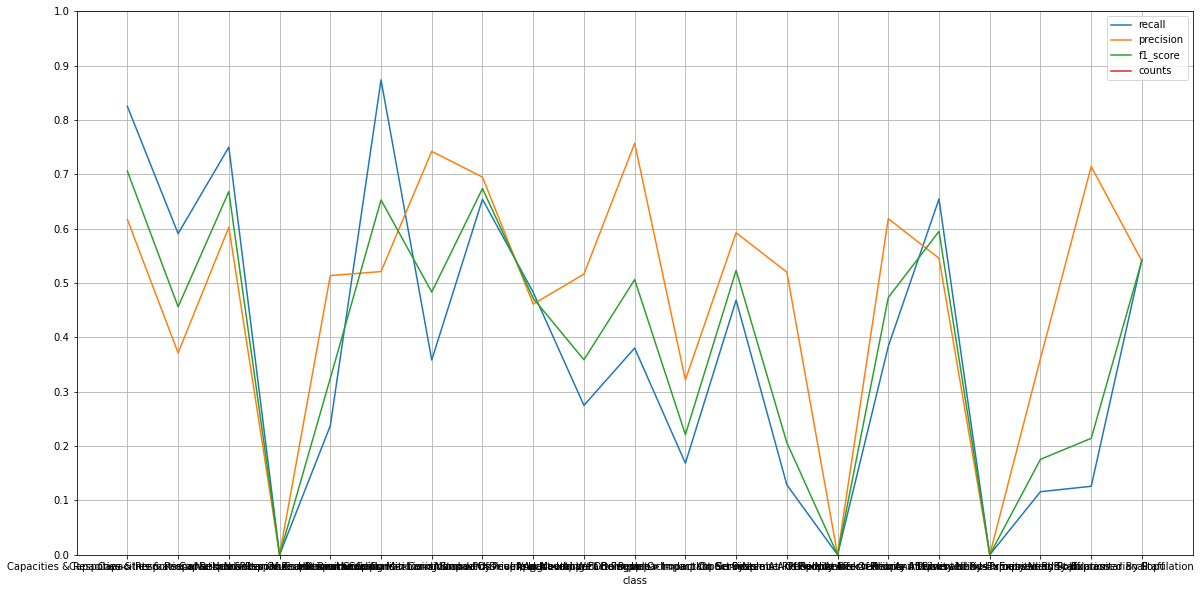

In [29]:
multi_label_metrics.plot(figsize=(20, 10), xticks=range(len(classes)+1), yticks=[x/10 for x in range(11)], ylim=(0, 1), grid=True)

In [ ]:
base = Path('/home/ec2-user/SageMaker/experiments-dfs/models/fastai/results')

In [ ]:
with open(base / 'test_preds_subs.pickle', 'wb') as f:
    pickle.dump(multi_label_metrics, f)

In [ ]:
with open(base / 'multi_label_metrics.pickle', 'wb') as f:
    pickle.dump(multi_label_metrics, f)

# Analysis

In [ ]:
tp = test_discrete_preds
tt = test_discrete_targets

In [ ]:
test_df

In [ ]:
start = 0

In [ ]:
for sentence, sector,p, t, in zip(
    test_df.sentence_text.iloc[start:], 
    test_df.sector_ids.iloc[start:], 
    tp[start:], 
    tt[start:]
):
    if 1 or list(p) != list(t):
        print(sentence)
        t = [classes[i] for i, x in enumerate(t) if x]
        print('Expected:', ', '.join(t))
        p = [classes[i] for i, x in enumerate(p) if x]
        print('Predicted:', ', '.join(p))
    else:
        continue
    
    a = input()
    if a == 's':
        break
    